In [1]:
import sys
sys.path.append('../../')

In [174]:
from codes.docs.analysis import data_preprocessing
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import tqdm as tqdm
%matplotlib inline

from sklearn.linear_model import LinearRegression

In [5]:
european_diffusion_dataset_term_removed_zeros=pd.read_csv('./reduced_european_diffusion_dataset.csv')

In [233]:
#preprocess the PRS score
PRS_thresholds=['X1e.08','X1e.07','X1e.06','X1e.05','X0.0001','X0.001','X0.01','X0.05', 'X0.1', 'X0.5', 'X1']
adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term_removed_zeros[PRS_thresholds]),
np.array(european_diffusion_dataset_term_removed_zeros['Anc_PC1']),np.array(european_diffusion_dataset_term_removed_zeros['Anc_PC2']),np.array(european_diffusion_dataset_term_removed_zeros['Anc_PC3']))

In [185]:
def splitting_dataset_into_k_fold(X,y,k=5):
    """
    For nested_CV, divide the dataset into inner and outer folds
    Args:
        X= dataset
        y= label
        k= folds number
    return
        generator of format
            X_train,y_train,X_test, y_test
    """
    outer_cv=KFold(n_splits=k)
    for trainval_index,test_index in outer_cv.split(X,y):
        X_trainval=X[trainval_index,:]
        y_trainval=y[trainval_index]
        X_test=X[test_index,:]
        y_test=y[test_index]
        yield (X_trainval,y_trainval,X_test,y_test)

def get_model_bias(y_true, y_pred):
    model_error=y_true - y_pred
    lin_reg=LinearRegression()
    lin_reg.fit(y_true.reshape(-1,1),model_error)
    coeff=lin_reg.coef_
    intercept=lin_reg.intercept_
    
    return (coeff,intercept)

In [304]:
X=np.array(european_diffusion_dataset_term_removed_zeros.iloc[:,5:2518])
y=np.array(european_diffusion_dataset_term_removed_zeros['PMA.at.birth'])

In [77]:
from sklearn.ensemble import RandomForestRegressor

In [151]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr

In [82]:
scoring={'r2':'r2','MAE':'neg_mean_absolute_error','MSE':'neg_mean_squared_error'}

In [153]:
def print_scores(y_pred,y_true):
    return {'r2': r2_score(y_true,y_pred),
    'MAE': mean_absolute_error(y_true,y_pred),
    'MSE': mean_squared_error(y_true,y_pred),
    'Correlation':pearsonr(y_true,y_pred)[0],
    'p_value':pearsonr(y_true,y_pred)[1]}

In [ ]:
data_preprocessing.high_low_risk_divide(european_diffusion_dataset_term_removed_zeros)

In [302]:
data_splitting=splitting_dataset_into_k_fold(X,y,k=5)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(5)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    pipeline=Pipeline([('scaler',MinMaxScaler()),('RFregressor',regr)])
    pipeline.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #calculate brain_maturation_index
    #y_total_pred=pipeline.predict(X)
    #y_total_pred=y_total_pred+y_total_pred*bias_coeff+bias_intercept
    #y_pred_dict[i]=y_total_pred

100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


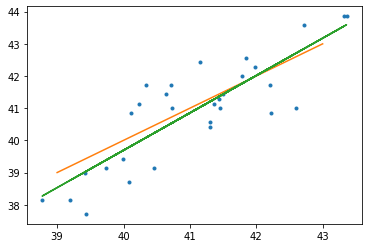

In [303]:
plt.plot(y_pred,y_test,'.')
plt.plot([39,43],[39,43])
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
y_pred_pred=lin_reg.predict(y_pred.reshape(-1,1))
plt.plot(y_pred,y_pred_pred)

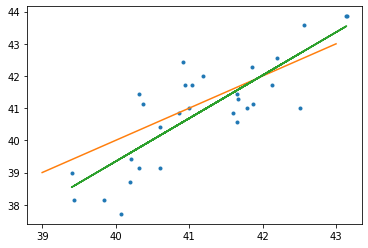

In [301]:
plt.plot(y_pred,y_test,'.')
plt.plot([39,43],[39,43])
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
y_pred_pred=lin_reg.predict(y_pred.reshape(-1,1))
plt.plot(y_pred,y_pred_pred)

In [ ]:
plt.plot(,y_test,'.')
plt.plot([39,43],[39,43])
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
y_pred_pred=lin_reg.predict(y_pred.reshape(-1,1))
plt.plot(y_pred,y_pred_pred)

In [247]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.755393,0.836289,0.999489,0.906016,2.387612e-12
1,0.627037,0.783678,1.088824,0.796399,1.412240e-07
2,0.691209,0.678053,0.751384,0.833870,1.048746e-08
3,0.600517,0.768432,1.032134,0.779883,3.768604e-07
4,0.600126,0.828740,1.041569,0.831695,1.240460e-08
5,0.654856,0.779038,0.982680,0.829573,1.081958e-07


In [248]:
brain_index=pd.DataFrame(y_pred_dict)
brain_index['mean_PMA_pred']=brain_index.mean(axis=1)
brain_index['true_PMA_pred']=y
brain_index['residual']=brain_index['mean_PMA_pred']-brain_index['true_PMA_pred']

In [249]:
brain_index

,0,1,2,3,4,mean_PMA_pred,true_PMA_pred,residual
0,39.402484,37.599320,37.380115,37.783613,37.359912,37.905089,37.428571,0.476517
1,42.249327,43.618416,43.462893,43.335536,43.377490,43.208733,43.428571,-0.219839
2,43.117473,44.456097,44.421255,44.233152,44.070966,44.059789,44.428571,-0.368783
3,40.535584,39.296871,39.477236,39.667499,39.485079,39.692454,39.142857,0.549597
4,40.997843,41.521441,41.489796,41.351915,41.610246,41.394248,41.857143,-0.462895
...,...,...,...,...,...,...,...,...
146,39.565966,39.563154,39.279926,39.085711,39.742336,39.447419,39.428571,0.018847
147,37.840948,37.715818,38.344114,37.922134,39.938075,38.352218,37.714286,0.637932
148,40.569408,40.844639,40.458148,40.387808,40.217702,40.495541,41.142857,-0.647316
149,38.647084,38.997304,39.054430,38.714474,40.055518,39.093762,38.714286,0.379476


In [261]:
brain_index_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds,'Correlation':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[0] for i in range(11)],'p-value':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[1] for i in range(11)]})

In [262]:
brain_index_corr

,PRS_threshold,Correlation,p-value
0,X1e.08,-0.081318,0.320908
1,X1e.07,-0.086272,0.292210
2,X1e.06,-0.093681,0.252573
3,X1e.05,-0.088256,0.281212
4,X0.0001,-0.116874,0.152965
5,X0.001,-0.096708,0.237496
6,X0.01,-0.194100,0.016936
7,X0.05,-0.212510,0.008802
8,X0.1,-0.197858,0.014882
9,X0.5,-0.200332,0.013651


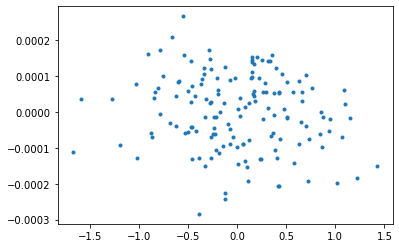

In [306]:
plt.plot(brain_index['residual'],adjusted_prs_score[:,7],'.')

In [263]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [265]:
prefrontal_lobes=['SFGdor','ORBsup','MFG','ORBmid','IFGoperc','IFGtriang','ORBinf','SFGmed','ORBsumed']
cingulum=['ACG','DCG','PCG']
subcortical=['HIP','PHG','AMYG','CAU','PUT','PAL','THA','INS']
temporal=['STG','TPOsup','MTG','TPOmid','ITG']
occipital=['REC','CUN','CAL','LING','SOG','MOG','IOG','FFG']
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [266]:
temp_connectivity_list_ROIs=[region for region in data_preprocessing.lower_triangle(ROIs_combinations) for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[0]]
connectivity_list_ROIs=[region for region in temp_connectivity_list_ROIs for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[1]]

In [275]:
X=np.asarray(european_diffusion_dataset_term_removed_zeros[[i for i in connectivity_list_ROIs if i in european_diffusion_dataset_term_removed_zeros.columns]])
y=np.array(european_diffusion_dataset_term_removed_zeros['PMA.at.birth'])

In [276]:
data_splitting=splitting_dataset_into_k_fold(X,y,k=5)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(5)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    pipeline=Pipeline([('scaler',MinMaxScaler()),('RFregressor',regr)])
    pipeline.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #calculate brain_maturation_index
    y_total_pred=pipeline.predict(X)
    y_total_pred=y_total_pred+y_total_pred*bias_coeff+bias_intercept
    y_pred_dict[i]=y_total_pred

100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


In [277]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.734696,0.863294,1.084056,0.887778,2.769498e-11
1,0.691883,0.747524,0.899514,0.836464,8.557686e-09
2,0.571152,0.796261,1.043520,0.760020,1.104856e-06
3,0.465032,0.968133,1.382181,0.686893,2.763902e-05
4,0.717042,0.713476,0.737031,0.874248,2.762367e-10
5,0.635961,0.817738,1.029261,0.809081,5.750548e-06


In [278]:
brain_index=pd.DataFrame(y_pred_dict)
brain_index['mean_PMA_pred']=brain_index.mean(axis=1)
brain_index['true_PMA_pred']=y
brain_index['residual']=brain_index['mean_PMA_pred']-brain_index['true_PMA_pred']

In [279]:
brain_index_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds,'Correlation':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[0] for i in range(11)],'p-value':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[1] for i in range(11)]})
brain_index_corr

,PRS_threshold,Correlation,p-value
0,X1e.08,-0.067966,0.406994
1,X1e.07,-0.071368,0.383859
2,X1e.06,-0.071514,0.382885
3,X1e.05,-0.063584,0.437971
4,X0.0001,-0.094008,0.250912
5,X0.001,-0.079683,0.330764
6,X0.01,-0.145131,0.075402
7,X0.05,-0.161967,0.046936
8,X0.1,-0.153344,0.060136
9,X0.5,-0.152774,0.061106


In [ ]:
plt.plot()

In [281]:
X=np.asarray(european_diffusion_dataset_term_removed_zeros[[i for i in connectivity_list_ROIs if i in european_diffusion_dataset_term_removed_zeros.columns]])
y=np.array(european_diffusion_dataset_term_removed_zeros['PMA.at.birth'])

In [286]:
data_splitting=splitting_dataset_into_k_fold(X,y,k=5)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(5)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    pipeline=Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=1)),('RFregressor',regr)])
    pipeline.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #calculate brain_maturation_index
    y_total_pred=pipeline.predict(X)
    y_total_pred=y_total_pred+y_total_pred*bias_coeff+bias_intercept
    y_pred_dict[i]=y_total_pred

100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


In [287]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.557144,1.106079,1.809550,0.753987,9.701348e-07
1,0.161479,1.291396,2.447969,0.601070,4.436980e-04
2,-0.097452,1.416533,2.670442,0.512832,3.757923e-03
3,0.258628,1.059618,1.915464,0.657584,7.862737e-05
4,0.182292,1.146366,2.129916,0.617347,2.788538e-04
5,0.212418,1.203998,2.194668,0.628564,9.120145e-04


In [288]:
brain_index=pd.DataFrame(y_pred_dict)
brain_index['mean_PMA_pred']=brain_index.mean(axis=1)
brain_index['true_PMA_pred']=y
brain_index['residual']=brain_index['mean_PMA_pred']-brain_index['true_PMA_pred']

In [289]:
brain_index_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds,'Correlation':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[0] for i in range(11)],'p-value':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[1] for i in range(11)]})
brain_index_corr

,PRS_threshold,Correlation,p-value
0,X1e.08,-0.094409,0.248890
1,X1e.07,-0.109261,0.181722
2,X1e.06,-0.087957,0.282850
3,X1e.05,-0.072906,0.373669
4,X0.0001,-0.083216,0.309705
5,X0.001,-0.053845,0.511417
6,X0.01,-0.085599,0.296008
7,X0.05,-0.143565,0.078643
8,X0.1,-0.133181,0.103053
9,X0.5,-0.173206,0.033436
